<h1><strong>IMPORT</strong></h1>

In [1]:
import dask.dataframe as dd
from dask import delayed
from fastparquet import ParquetFile
import glob
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
from transformers import BertTokenizerFast, AutoTokenizer
import multiprocessing
import random
from datetime import datetime
from matplotlib import pyplot as plt
import pandas as pd

@delayed
def load_chunk(pth):
    x = ParquetFile(pth).to_pandas()
    return x

files = glob.glob('/home/maxim/Downloads/MERT-DATA/')

ddf = dd.from_delayed([load_chunk(f) for f in files])
df = ddf.compute()

seed = 42

torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)


BATCH_SIZE = 16
MAX_SEQ_LEN = 512
VOCAB_SIZE = 30000
NUM_HEADS = 12
POS_ENC_LEN = MAX_SEQ_LEN
EMB_DIM = 768
FEED_FORWARD_DIM = EMB_DIM * 4
NUM_LAYERS = 12

<h1><strong>PREPROCESS DATA</strong></h1>

In [2]:
# df = df[0:1000000]

In [3]:
df = df.dropna()

In [4]:
df.head()

,text
0,"usually , he would be tearing around the livin..."
1,but just one look at a minion sent him practic...
2,that had been megan 's plan when she got him d...
3,"he 'd seen the movie almost by mistake , consi..."
4,she liked to think being surrounded by adults ...


In [5]:
df.shape

(7804000, 1)

<h1><strong>TOKENIZATION</strong></h1>

In [6]:
def batch_iterator(batch_size=BATCH_SIZE):
    for i in tqdm(range(0, len(df), batch_size)):
        yield df[i : i + batch_size]["text"]

tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

In [7]:
bert_tokenizer = tokenizer.train_new_from_iterator(text_iterator=batch_iterator(), vocab_size=VOCAB_SIZE)
bert_tokenizer.save_pretrained("tokenizer")

100%|██████████| 487750/487750 [00:42<00:00, 11535.89it/s]


('tokenizer/tokenizer_config.json',
 'tokenizer/special_tokens_map.json',
 'tokenizer/vocab.txt',
 'tokenizer/added_tokens.json',
 'tokenizer/tokenizer.json')

In [8]:
tokenizer = AutoTokenizer.from_pretrained("tokenizer")
num_proc = multiprocessing.cpu_count()

def batch_encode(data):
    yield tokenizer(
        data,
        max_length=MAX_SEQ_LEN,
        return_special_tokens_mask=True,
        truncation=True
    )

for i in range(0, df.shape[0], BATCH_SIZE):
    tokenized_batch = []

    if i + BATCH_SIZE > df.shape[0]:
        break

    for text in df['text'][i:i + BATCH_SIZE]:
        tokenized_batch.append(next(batch_encode(text)))

In [9]:
VOCAB = tokenizer.get_vocab()
VOCAB_FLIP = {val: key for key, val in VOCAB.items()}

In [10]:
VOCAB["[PAD]"]

0

In [11]:
keys = list(VOCAB.values())
vals = list(VOCAB.keys())

In [12]:
print("Original key list is : " + str(keys))
print("Original value list is : " + str(vals))

res = {}
for key in keys:
    for value in vals:
        res[key] = value
        vals.remove(value)
        break

Original key list is : [7712, 10181, 9706, 20411, 7534, 19251, 26499, 12434, 2812, 2406, 14812, 6524, 20977, 24608, 22131, 17845, 9498, 3064, 6305, 10526, 24427, 7758, 15694, 28397, 28664, 19133, 2549, 3817, 4864, 13092, 16495, 1497, 549, 24795, 3012, 1272, 15780, 17947, 12334, 19984, 27380, 29932, 6362, 11968, 7295, 17648, 15868, 3790, 6723, 6361, 20072, 26212, 21712, 10344, 5086, 10528, 2370, 4895, 8637, 2510, 23020, 27216, 29950, 4594, 9908, 16285, 10163, 27610, 28756, 25974, 27509, 24708, 13593, 16867, 29970, 21294, 13238, 22746, 5680, 16480, 17411, 17331, 25264, 7076, 23225, 4635, 7695, 27804, 908, 118, 292, 15730, 16971, 20215, 5941, 8570, 12921, 28593, 20684, 28267, 22371, 21827, 17603, 13908, 14291, 26389, 27653, 10295, 25605, 4409, 21921, 22627, 26506, 7326, 17726, 29852, 1193, 5750, 2095, 10183, 16615, 16468, 26887, 18728, 2078, 6438, 4798, 3613, 9634, 13188, 15732, 19353, 23816, 22926, 9897, 15706, 12650, 5265, 15529, 18228, 11081, 28135, 16074, 24815, 20016, 8520, 1185, 231

In [13]:
for token in tokenized_batch[0]['input_ids']:
    print(res[token])

[CLS]
the
gasoline
in
the
tank
did
a
nice
pop
-
and
-
flare
that
turned
to
a
pitiful
stream
of
black
smoke
under
the
drenching
mist
and
rain
.
[SEP]


<h1><strong>EMBEDDINGS</strong></h1>

In [14]:
class PositionalEmbedding(nn.Module):
    def __init__(self, d_model, max_len):
        super().__init__()

        pe = torch.zeros(max_len, d_model, device='cuda').float()
        pe.require_grad = False

        for pos in range(max_len):
            for i in range(0, d_model, 2):
                pe[pos, i] = math.sin(pos / (10000 ** ((2 * i)/d_model)))
                pe[pos, i + 1] = math.cos(pos / (10000 ** ((2 * (i + 1))/d_model)))

        self.pe = pe.unsqueeze(0)

    def forward(self, x):
        return self.pe

In [15]:
class MERTEmbedding(nn.Module):
    def __init__(self, vocab_size, embed_size, seq_len, dropout=0.1):
        super().__init__()
        self.token = nn.Embedding(vocab_size, embed_size, padding_idx=0)
        self.position = PositionalEmbedding(d_model=embed_size, max_len=seq_len)
        self.dropout = nn.Dropout(p=dropout)
       
    def forward(self, sequence):
        x = self.token(sequence) + self.position(sequence)
        return self.dropout(x)

<h1><strong>ATTENTION</strong></h1>

In [16]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, heads, d_model, dropout=0.1):
        super().__init__()
        
        assert d_model % heads == 0
        self.d_k = d_model // heads
        self.heads = heads
        self.dropout = nn.Dropout(dropout)

        self.query = nn.Linear(d_model, d_model)
        self.key = nn.Linear(d_model, d_model)
        self.value = nn.Linear(d_model, d_model)
        self.output_linear = nn.Linear(d_model, d_model)
        
    def forward(self, query, key, value, mask):
        query = self.query(query)
        key = self.key(key)        
        value = self.value(value)

        query = query.view(query.shape[0], -1, self.heads, self.d_k).permute(0, 2, 1, 3)   
        key = key.view(key.shape[0], -1, self.heads, self.d_k).permute(0, 2, 1, 3)  
        value = value.view(value.shape[0], -1, self.heads, self.d_k).permute(0, 2, 1, 3)  
        
        scores = torch.matmul(query, key.permute(0, 1, 3, 2)) / math.sqrt(query.size(-1))
        scores = scores.masked_fill(mask == 0, -1e4)

        weights = F.softmax(scores, dim=-1)           
        weights = self.dropout(weights)

        context = torch.matmul(weights, value)
        context = context.permute(0, 2, 1, 3).contiguous().view(context.shape[0], -1, self.heads * self.d_k)

        return self.output_linear(context)

<h1><strong>OPTIMIZER</strong></h1>

In [17]:
class ScheduledOptim():
    def __init__(self, optimizer, d_model, n_warmup_steps):
        self.optimizer = optimizer
        self.n_warmup_steps = n_warmup_steps
        self.n_current_steps = 0
        self.init_lr = np.power(d_model, -0.5)

    def step_and_update_lr(self, scalar):
        self.update_learning_rate()
        scalar.step(self.optimizer)

    def zero_grad(self):
        self.optimizer.zero_grad()

    def get_lr_scale(self):
        return np.min([
            np.power(self.n_current_steps, -0.5),
            np.power(self.n_warmup_steps, -1.5) * self.n_current_steps])

    def update_learning_rate(self):
        self.n_current_steps += 1
        lr = self.init_lr * self.get_lr_scale()

        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr

<h1><strong>MODEL</strong></h1>

In [18]:
class FeedForward(nn.Module):
    def __init__(self, d_model, middle_dim=FEED_FORWARD_DIM, dropout=0.1):
        super().__init__()
        
        self.fc1 = nn.Linear(d_model, middle_dim)
        self.fc2 = nn.Linear(middle_dim, d_model)
        self.dropout = nn.Dropout(dropout)
        self.activation = nn.GELU()

    def forward(self, x):
        out = self.activation(self.fc1(x))
        out = self.fc2(self.dropout(out))
        return out

In [19]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model=EMB_DIM, heads=NUM_HEADS, feed_forward_hidden=FEED_FORWARD_DIM, dropout=0.1):
        super().__init__()

        self.layernorm = nn.LayerNorm(d_model)
        self.self_multihead = MultiHeadedAttention(heads, d_model)
        self.feed_forward = FeedForward(d_model, middle_dim=feed_forward_hidden)
        self.dropout = nn.Dropout(dropout)

    def forward(self, embeddings, mask):
        interacted = self.dropout(self.self_multihead(embeddings, embeddings, embeddings, mask))
        interacted = self.layernorm(interacted + embeddings)

        feed_forward_out = self.dropout(self.feed_forward(interacted))
        encoded = self.layernorm(feed_forward_out + interacted)
        return encoded

In [20]:
class MERT(nn.Module):
    def __init__(self, vocab_size = VOCAB_SIZE, d_model=EMB_DIM, n_layers=NUM_LAYERS, heads=NUM_HEADS, feed_forward_dim=FEED_FORWARD_DIM, seq_len=MAX_SEQ_LEN, dropout=0.1):
        super().__init__()
        self.d_model = d_model
        self.n_layers = n_layers
        self.heads = heads

        self.feed_forward_hidden = feed_forward_dim
        
        self.embedding = MERTEmbedding(vocab_size=vocab_size, embed_size=d_model, seq_len=seq_len)

        self.encoder_blocks = nn.ModuleList(
            [EncoderLayer(d_model, heads, feed_forward_dim, dropout) for _ in range(n_layers)])
        
    def save(self, step, epoch = None, optim = None):
        now = datetime.now()

        dt_string = now.strftime("%d|%m|%Y %H:%M:%S")
        
        if epoch == None:
            torch.save(self, "saves/MERT_time: " + dt_string + "|step: " + step.__str__()  + ".pt")
        else:
            torch.save(self, "saves/MERT_time: " + dt_string + "|epoch: " + epoch.__str__()  + ".pt")

    def forward(self, x):
        mask = (x>0).unsqueeze(1).repeat(1, x.size(1), 1).unsqueeze(1).to('cuda')

        x = self.embedding(x)

        for encoder in self.encoder_blocks:
            x = encoder.forward(x, mask)
        return x

<h1><strong>Language Model</strong></h1>

In [21]:
class MaskedLanguageModel(nn.Module):
    def __init__(self, hidden, vocab_size):
        super().__init__()
        self.linear = torch.nn.Linear(hidden, vocab_size)
        self.softmax = torch.nn.LogSoftmax(dim=-1)

    def forward(self, x):
        return self.softmax(self.linear(x))

class MERTLM(nn.Module):
    def __init__(self, bert: MERT, emb_dim, vocab_size):
        super().__init__()
        self.bert = bert
        self.mask_lm = MaskedLanguageModel(emb_dim, vocab_size)

    def save(self, step, epoch = None, optim = None):
        self.bert.save(step, epoch, optim)

    def forward(self, x):
        x = self.bert(x)
        return self.mask_lm(x)

<h1><strong>TRAINING</strong></h1>

In [22]:
class MERTTrainer:
    def __init__(self, model, train, tokenizer, test=None, lr = 1e-4, weight_decay=0.01,
                betas=(0.9, 0.999), warmup_steps=10000, log_freq=10, device='cuda'):
        self.device = device
        self.model = torch.compile(model.to('cuda'))
        self.train_data = train
        self.test_data = test

        self.scaler = torch.cuda.amp.GradScaler()

        self.optim = torch.optim.Adam(model.parameters(), lr=1e-4, betas=(0.9, 0.999), weight_decay=0.01)
        self.optim_schedule = ScheduledOptim(self.optim, EMB_DIM, n_warmup_steps=10000)

        self.criterion = torch.nn.NLLLoss(ignore_index=0)
        self.log_freq = log_freq
        print("Total Parameters:", sum([p.nelement() for p in self.model.parameters()]))
    
    def train(self, epoch):
        self.iteration(epoch, self.train_data)

    def test(self, epoch):
        self.iteration(epoch, self.test_data, train=False)

    def iteration(self, epoch, data_loader, train=True):
        loss_sum_epoch = 0
        loss_sum_steps = 0
        step = 0
        step_no_reset = 0
        loss_graph = []

        cola = 0

        if train:
            self.model.train()
        else:
            self.model.eval()

        # data_iter = tqdm.tqdm(
        #     enumerate(data_loader),
        #     desc="EP_%s:%d" % (mode, epoch),
        #     total=len(data_loader),
        #     bar_format="{l_bar}{r_bar}"
        # )

        for i in range(0, df.shape[0], BATCH_SIZE):
            data = []
            labels = []

            if i + BATCH_SIZE > df.shape[0]:
                break

            for text in df['text'][i:i + BATCH_SIZE]:
                sentence = []
                label_sentence = []
                encoding = next(batch_encode(text))

                for token in encoding['input_ids']:
                    prob = random.random()
                    if prob < 0.15:
                        prob /= 0.15
                        if prob < 0.8:
                            sentence.append(VOCAB["[MASK]"])
                        elif prob < 0.9:
                            sentence.append(random.randrange(VOCAB_SIZE))
                        else:
                            sentence.append(token)

                        label_sentence.append(token)
                    else:
                        sentence.append(token)
                        label_sentence.append(0)

                padding = [VOCAB['[PAD]'] for _ in range(MAX_SEQ_LEN - len(sentence))]
                sentence.extend(padding)
                label_sentence.extend(padding)

                sentence = torch.as_tensor(sentence)
                label_sentence = torch.as_tensor(label_sentence)

                data.append(sentence.to(self.device))
                labels.append(label_sentence.to(self.device))

            data = torch.stack(data).cuda()
            labels = torch.stack(labels).cuda()

            with torch.cuda.amp.autocast():
                print(data.shape)
                mask_lm_output = self.model.forward(data)

            mask_loss = self.criterion(mask_lm_output.transpose(1, 2), labels)
            loss = mask_loss
            loss_sum_steps += loss
            loss_sum_epoch += loss

            if train:
                self.optim_schedule.zero_grad()
                self.scaler.scale(loss).backward()
                self.optim_schedule.step_and_update_lr(self.scaler)

            if step_no_reset % 10000 == 0:
                temp = pd.DataFrame()
                temp['data'] = np.array(torch.as_tensor(loss_graph, device='cpu'))
                moving_average = temp['data'].rolling(window=5).mean()
                moving_average_large = temp['data'].rolling(window=15).mean()
                plt.plot(torch.as_tensor(loss_graph, device='cpu'), label="Original Data", color='black')
                plt.plot(torch.as_tensor(moving_average, device='cpu'), label="Scaled Data", color='pink')
                plt.plot(torch.as_tensor(moving_average_large, device='cpu'), label="Scaled Data_10", color='blue')
                plt.ylabel("loss")
                plt.savefig("saves/loss_" + str(step_no_reset) + ".png")

            if step_no_reset % 10000 == 0:
                self.model.save(step_no_reset)
            
            if step % 100 == 0:
                print(loss_sum_steps / step)
                loss_sum_steps = 0
                step = 0
                loss_graph.append(loss)
            step += 1
            step_no_reset += 1

            self.scaler.update()

        print(
            f"EP{epoch}, AVG LOSS{loss_sum_epoch / i}"
        )
        self.model.save(0, epoch)

        plt.plot(loss_graph)
        plt.ylabel("loss")
        plt.savefig("saves/loss_" + str(step_no_reset) + ".png")

In [23]:
TOKENIZERS_PARALLELISM=True

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Total Parameters: 131146032
torch.Size([16, 512])
tensor(inf, device='cuda:0', grad_fn=<DivBackward0>)
torch.Size([16, 512])
torch.Size([16, 512])
torch.Size([16, 512])
torch.Size([16, 512])
torch.Size([16, 512])
torch.Size([16, 512])
torch.Size([16, 512])
torch.Size([16, 512])
torch.Size([16, 512])
torch.Size([16, 512])
torch.Size([16, 512])
torch.Size([16, 512])
torch.Size([16, 512])
torch.Size([16, 512])
torch.Size([16, 512])
torch.Size([16, 512])
torch.Size([16, 512])
torch.Size([16, 512])
torch.Size([16, 512])
torch.Size([16, 512])
torch.Size([16, 512])
torch.Size([16, 512])
torch.Size([16, 512])
torch.Size([16, 512])
torch.Size([16, 512])
torch.Size([16, 512])
torch.Size([16, 512])
torch.Size([16, 512])
torch.Size([16, 512])
torch.Size([16, 512])
torch.Size([16, 512])
torch.Size([16, 512])
torch.Size([16, 512])
torch.Size([16, 512])
torch.Size([16, 512])
torch.Size([16, 512])
torch.Size([16, 512])
torch.Size([16, 512])
torch.Size([16, 512])
torch.Size([16, 512])
torch.Size([16, 5

KeyboardInterrupt: 

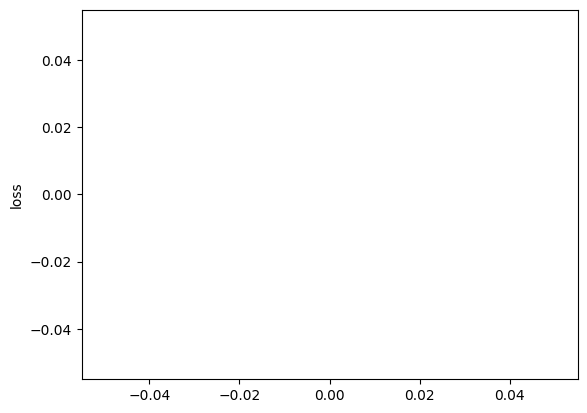

In [24]:
# model = MERT(VOCAB_SIZE, EMB_DIM, NUM_LAYERS, NUM_HEADS, FEED_FORWARD_DIM, 0.1)
model = torch.load('saves/MERT_time: 21|03|2024 13:58:21|epoch: 1.pt')
#~19 sec
#~12 sec compile
LM = MERTLM(model, emb_dim=EMB_DIM, vocab_size=VOCAB_SIZE)
trainer = MERTTrainer(LM, df, batch_encode)
trainer.train(1)

In [ ]:
masked_batch = ["Josh [MASK] very fat"] * BATCH_SIZE
original_batch = ["Josh is very fat"] * BATCH_SIZE

tokenized_masked_batch = []
tokenized_original_batch = []

for text in masked_batch:
    encoded = next(batch_encode(text))['input_ids']

    padding = [VOCAB['[PAD]'] for _ in range(MAX_SEQ_LEN - len(encoded))]
    encoded.extend(padding)

    tokenized_masked_batch.append(torch.tensor(encoded))

for text in original_batch:
    encoded = next(batch_encode(text))['input_ids']

    padding = [VOCAB['[PAD]'] for _ in range(MAX_SEQ_LEN - len(encoded))]
    encoded.extend(padding)

    tokenized_original_batch.append(torch.tensor(encoded))

In [ ]:
tokenized_masked_batch = torch.as_tensor(np.array(tokenized_masked_batch), device = 'cuda')
tokenized_original_batch = torch.as_tensor(np.array(tokenized_original_batch), device = 'cuda')

In [ ]:
tokenized_masked_batch

tensor([[   2, 6845,    4,  ...,    0,    0,    0],
        [   2, 6845,    4,  ...,    0,    0,    0],
        [   2, 6845,    4,  ...,    0,    0,    0],
        ...,
        [   2, 6845,    4,  ...,    0,    0,    0],
        [   2, 6845,    4,  ...,    0,    0,    0],
        [   2, 6845,    4,  ...,    0,    0,    0]], device='cuda:0')

In [ ]:
tokenized_original_batch

tensor([[   2, 6845,  256,  ...,    0,    0,    0],
        [   2, 6845,  256,  ...,    0,    0,    0],
        [   2, 6845,  256,  ...,    0,    0,    0],
        ...,
        [   2, 6845,  256,  ...,    0,    0,    0],
        [   2, 6845,  256,  ...,    0,    0,    0],
        [   2, 6845,  256,  ...,    0,    0,    0]], device='cuda:0')

                                                   text
0     Our friends won't buy this analysis, let alone...
1     One more pseudo generalization and I'm giving up.
2      One more pseudo generalization or I'm giving up.
3        The more we study verbs, the crazier they get.
4             Day by day the facts are getting murkier.
...                                                 ...
8546                   Poseidon appears to own a dragon
8547                     Digitize is my happiest memory
8548                     It is easy to slay the Gorgon.
8549       I had the strangest feeling that I knew you.
8550                What all did you get for Christmas?

[8551 rows x 1 columns]
tensor(7.1513, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
tensor(inf, device='cuda:0', grad_fn=<DivBackward0>)


AssertionError: No inf checks were recorded prior to update.

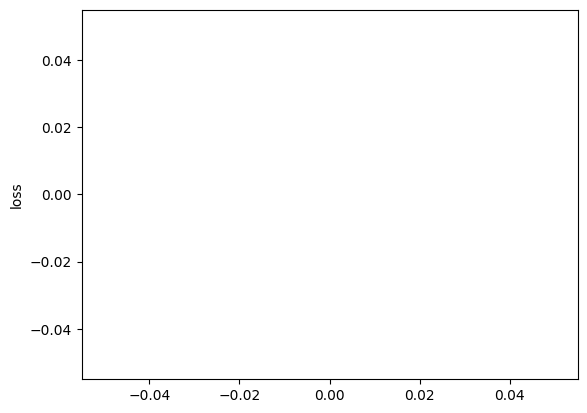

In [ ]:
import datasets

glue_dataset = datasets.load_dataset("glue", "cola")

df = pd.DataFrame()
df['text'] = glue_dataset['train']['sentence']
ddf = dd.from_pandas(df, npartitions=1).compute()

print(ddf)

model = trainer
model.test_data = ddf

predictions = model.test(1)

glue_metric = datasets.load_metric("glue", "cola")
glue_score = glue_metric.compute(predictions=predictions, references=glue_dataset["labels"])

print(glue_score)